In [1]:
import pandas as pd
from ast import literal_eval
from sklearn.model_selection import train_test_split

# read from file
data_frame = pd.read_csv("../ProjectResources/movies/movies_metadata.csv", low_memory=False)

#create working copy
work_copy = data_frame.copy()
work_copy['budget'] = pd.to_numeric(work_copy['budget'], errors='coerce')

# clean the data
work_copy.dropna(axis='index', how='any', subset=['budget','vote_count','vote_average', 'revenue', 'genres'], inplace=True)
work_copy = work_copy[['budget','genres','vote_count', 'vote_average', 'revenue']]
# drop data with bad values
work_copy = work_copy.drop(work_copy[work_copy.revenue == 0].index)
work_copy = work_copy.drop(work_copy[work_copy.budget == 0].index)
work_copy = work_copy.drop(work_copy[work_copy.vote_count == 0].index)

# oject under genres can have multiple values, expand the dataset by creating multiple rows for the
# same movie but with a single genre. These single genre items will be in {id: #, name: "genre_name"} format
work_copy['genres'] = work_copy['genres'].apply(literal_eval)
work_copy = work_copy.explode("genres")
work_copy.dropna(axis='index', how='any', subset=['genres'], inplace=True)
work_copy['genres'] = [d.get('name') for d in work_copy['genres']]

# Encode the genres into integers.
from sklearn.preprocessing import LabelEncoder
work_copy['genre_int'] = LabelEncoder().fit_transform(work_copy['genres'])

# create training and test sets
train_set, test_set = train_test_split(work_copy, test_size=0.2, random_state=27)

In [2]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11200 entries, 10445 to 5678
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   budget        11200 non-null  float64
 1   genres        11200 non-null  object 
 2   vote_count    11200 non-null  float64
 3   vote_average  11200 non-null  float64
 4   revenue       11200 non-null  float64
 5   genre_int     11200 non-null  int32  
dtypes: float64(4), int32(1), object(1)
memory usage: 568.8+ KB


In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

model = Pipeline([
    ('addQuad', PolynomialFeatures(degree=2)),
    ('scale', StandardScaler()),
    ('svm', SVC(kernel="linear"))
    ]
)

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier

# model_logreg = LogisticRegression(solver="lbfgs")
model_svm = SVC(kernel="rbf")
model_random_forest = RandomForestClassifier(n_estimators=10)
model_decision_tree = DecisionTreeClassifier()

ensemble = VotingClassifier(
    voting= "hard",
    estimators = [
        # ("logreg", model_logreg),
        ("svm", model_svm),
        ("randfor", model_random_forest),
        ("desitree", model_decision_tree),
        ('quad', model)
    ]
)

In [5]:
from sklearn.metrics import accuracy_score, f1_score
X = train_set[["vote_average", "revenue", "budget", "vote_count"]]
y = train_set['genre_int']

ensemble.fit(X, y)
y_pred = ensemble.predict(X)
print("Ensemble has accuracy ", accuracy_score(y, y_pred))
print("Ensemble has f1_score ", f1_score(y, y_pred, average="weighted"))

X_test = test_set[["vote_average", "revenue", "budget", "vote_count"]]
y_test = test_set['genre_int']

ensemble = ensemble = VotingClassifier(
    voting= "hard",
    estimators = [
        # ("logreg", model_logreg),
        ("svm", model_svm),
        ("randfor", model_random_forest),
        ("desitree", model_decision_tree),
        ('quad', model)
    ]
)
ensemble.fit(X_test, y_test)
y_test_pred = ensemble.predict(X_test)
print("Ensemble on test has accuracy ", accuracy_score(y_test, y_test_pred))
print("Ensemble on test has f1_score ", f1_score(y_test, y_test_pred, average="weighted"))

Ensemble has accuracy  0.3366071428571429
Ensemble has f1_score  0.2618659484250905
Ensemble on test has accuracy  0.5357142857142857
Ensemble on test has f1_score  0.4819498325649492


The ensemble built from the Voting classifier performs in the midrange of the models tested overall. Based on the results below the data has to be a bit skewed on the test set. In the linear decision tree analysis vs svc it is shown that svc is not good at predicting most genres, but it does ok predicting a few of them.w

In [11]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

train_f1_scores = {}
train_accuracy_scores = {}
reports = {}
print("One train set")
for classifier in [model_svm, model_random_forest, model_decision_tree, model]:
    classifier.fit(X, y)
    y_pred = classifier.predict(X)
    
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average="weighted")
    name = classifier.__class__.__name__
    train_accuracy_scores[name] = acc
    train_f1_scores[name] = f1
    
     
    print(classifier.__class__.__name__, " has accuracy ", acc)
    print(classifier.__class__.__name__, " has f1_score ", f1)
    reports[name] = (classification_report(y, y_pred, output_dict= True))

print()
print("One Test set")
for classifier in [model_svm, model_random_forest, model_decision_tree, model]:
    classifier.fit(X_test, y_test)
    y__test_pred = classifier.predict(X_test)

    print(classifier.__class__.__name__, " on test has accuracy ", accuracy_score(y_test, y_test_pred))
    print(classifier.__class__.__name__, " on test has f1_score ", f1_score(y_test, y_test_pred, average="weighted"))
    
    

One train set
SVC  has accuracy  0.19955357142857144
SVC  has f1_score  0.09515548506853343


C:\Users\s539593\Documents\School\DataScience\ds-venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\s539593\Documents\School\DataScience\ds-venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\s539593\Documents\School\DataScience\ds-venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

RandomForestClassifier  has accuracy  0.4521428571428571
RandomForestClassifier  has f1_score  0.45129888895228404
DecisionTreeClassifier  has accuracy  0.4533035714285714
DecisionTreeClassifier  has f1_score  0.4014888659594106


C:\Users\s539593\Documents\School\DataScience\ds-venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\s539593\Documents\School\DataScience\ds-venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\s539593\Documents\School\DataScience\ds-venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Pipeline  has accuracy  0.21607142857142858
Pipeline  has f1_score  0.11974753360877076

One Test set


C:\Users\s539593\Documents\School\DataScience\ds-venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\s539593\Documents\School\DataScience\ds-venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\s539593\Documents\School\DataScience\ds-venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

SVC  on test has accuracy  0.5357142857142857
SVC  on test has f1_score  0.4819498325649492
RandomForestClassifier  on test has accuracy  0.5357142857142857
RandomForestClassifier  on test has f1_score  0.4819498325649492
DecisionTreeClassifier  on test has accuracy  0.5357142857142857
DecisionTreeClassifier  on test has f1_score  0.4819498325649492
Pipeline  on test has accuracy  0.5357142857142857
Pipeline  on test has f1_score  0.4819498325649492


The random forest and decision tree models outperfom all other models tested. At lower input sizes the descision tree performs similar to random forest, but as the data size grows random forest outperforms decision tree. This is because random forest performs multiple decision trees and tries to take the best result.

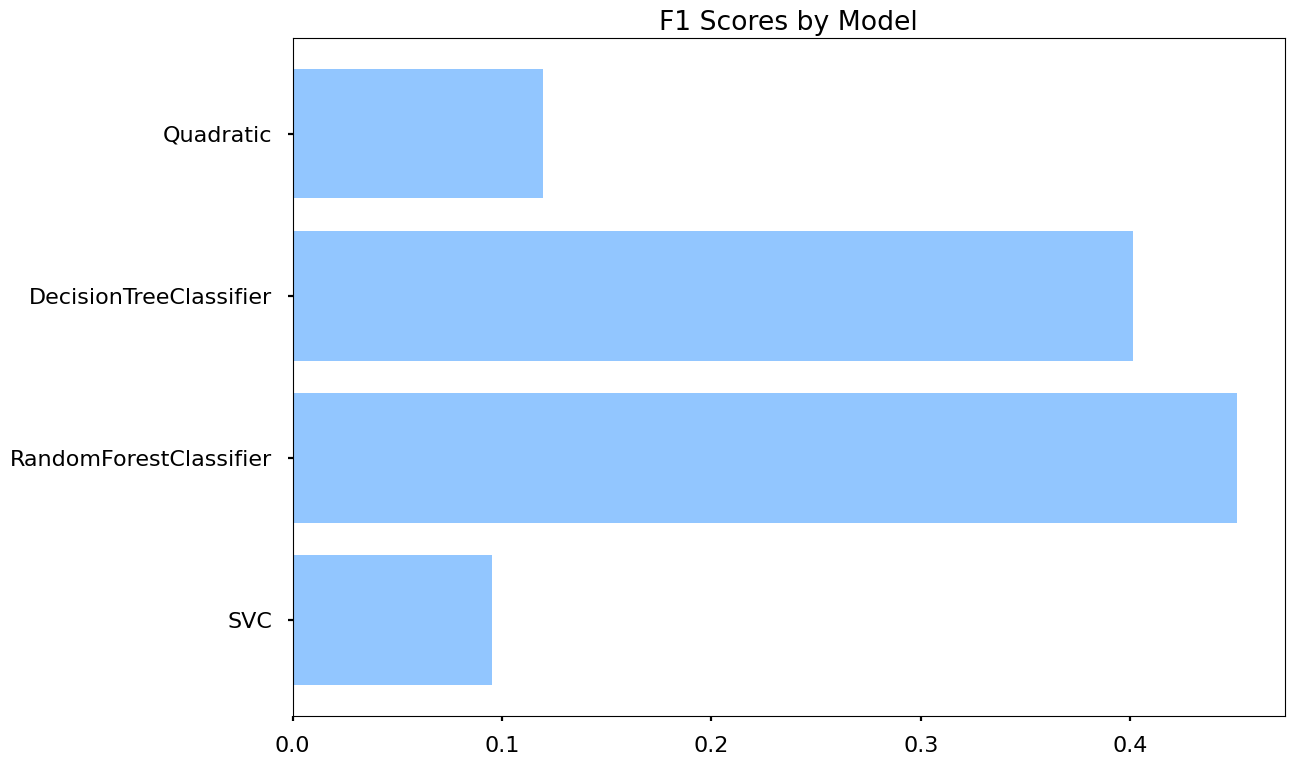

In [13]:
import matplotlib.pyplot as plt
fig, plot = plt.subplots()
plt.style.use('seaborn-v0_8-pastel')
plt.style.use('seaborn-v0_8-poster')
y_pos = [i for i in range(len(train_f1_scores))]
plot.barh(y_pos, [train_f1_scores[c] for c in train_f1_scores])
plot.set_yticks(y_pos, [c if c != "Pipeline" else "Quadratic" for c in train_f1_scores])
plot.set_title("F1 Scores by Model")
plt.savefig("fig/F1ScoreByModel", bbox_inches="tight")

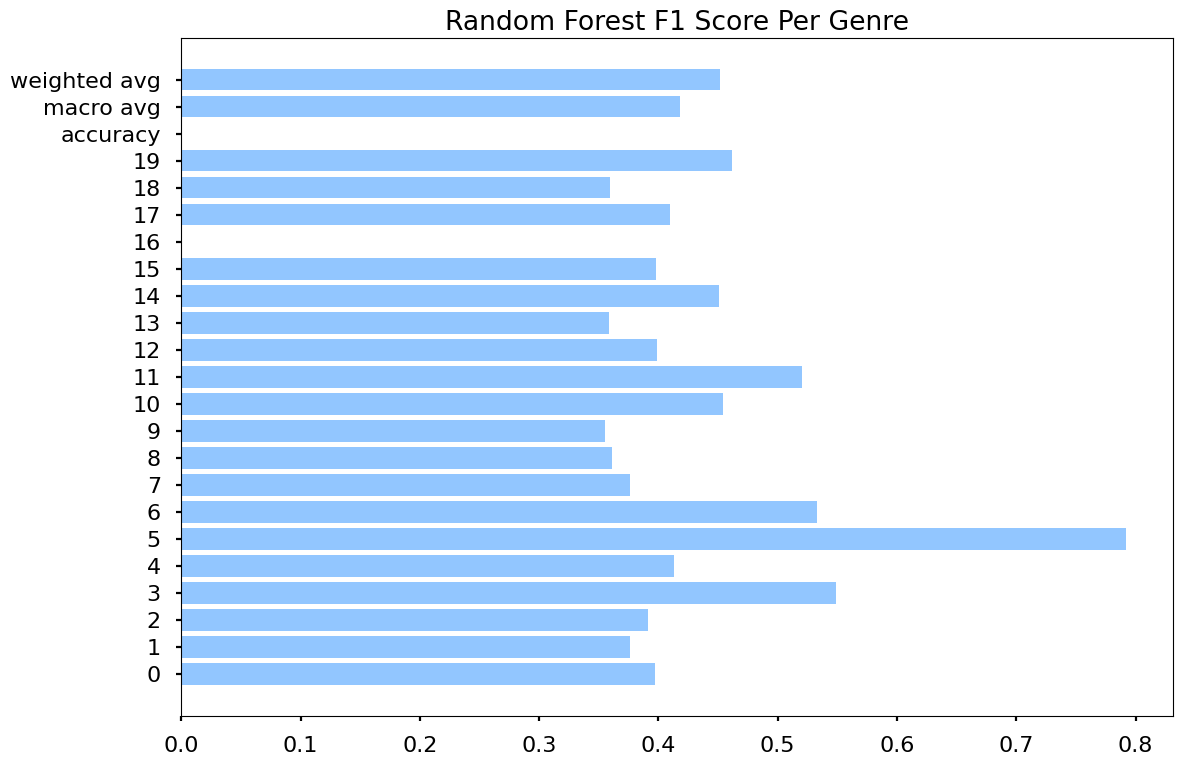

In [15]:
from pprint import pprint
import matplotlib.pyplot as plt
class_dict = reports["RandomForestClassifier"]
# del class_dict["accuracy"]
# del class_dict["weighted avg"]
# del class_dict["macro avg"]

fig, plot = plt.subplots()
plt.style.use('seaborn-v0_8-pastel')
plt.style.use('seaborn-v0_8-poster')
y_pos = [i for i in range(len(class_dict))]
plot.barh(y_pos, [class_dict[i]['f1-score'] if i != 'accuracy' else 0 for i in class_dict])
plot.set_yticks(y_pos, [i for i in class_dict])
plot.set_title("Random Forest F1 Score Per Genre")
plt.savefig("fig/RadomForestF1ScorePerGenre", bbox_inches="tight")

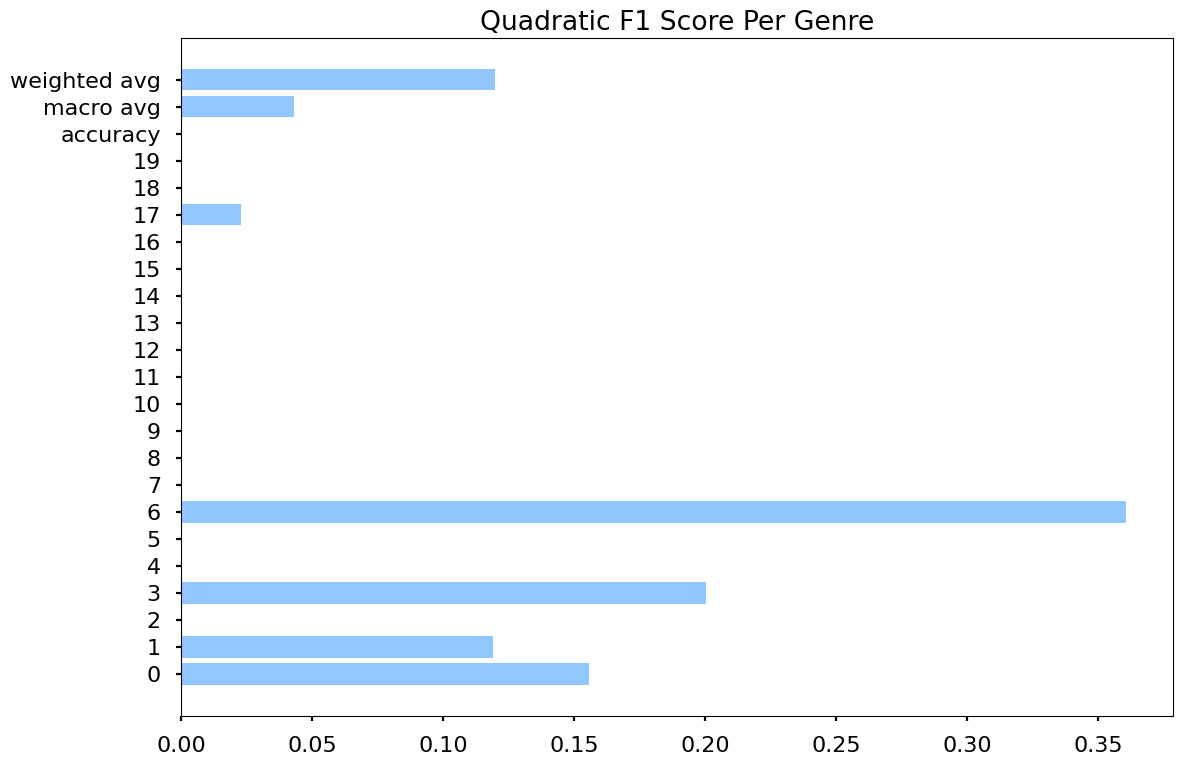

In [17]:
from pprint import pprint
import matplotlib.pyplot as plt
class_dict = reports["Pipeline"]
# del class_dict["accuracy"]
# del class_dict["weighted avg"]
# del class_dict["macro avg"]

fig, plot = plt.subplots()
plt.style.use('seaborn-v0_8-pastel')
plt.style.use('seaborn-v0_8-poster')
y_pos = [i for i in range(len(class_dict))]
plot.barh(y_pos, [class_dict[i]['f1-score'] if i != 'accuracy' else 0 for i in class_dict])
plot.set_yticks(y_pos, [i for i in class_dict])
plot.set_title("Quadratic F1 Score Per Genre")
plt.savefig("fig/QuadraticF1ScorePerGenre", bbox_inches="tight")